In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from py_vollib.black_scholes import black_scholes
from sklearn.metrics import mean_squared_error
import scipy.optimize as optimize
import random
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.ticker as ticker


#Heston
gamma = 0.5751
kappa = 1.5768
vbar  = 0.0484
rho   = -0.7
v0    = 0.1024

# Backbone Y
gamma_Y = 0.5751
kappa_Y = 1
vbar_Y  = 0.0144
v0_Y    = 0.0144

#****
r=0
S_0=1
sigma=0.3

#****
L=40
M=500
Lambda=0.00001
i = np.complex(0.0,1.0)

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
def GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S_0): 
    np.random.seed(111)
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])   
    
    X[:,0] = np.log(S_0)      
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])           
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma **2 ) * dt + sigma * np.power(dt, 0.5)*Z[:,i] 
    S = np.exp(X)  
    paths = {"S":S}
    return paths


def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0): 
    np.random.seed(111)
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])

        
    #Compute exponent
    S = np.exp(X)
    paths = {"S":S}
    return paths


def BS_Call_Option_Price(CP,K,S_0,sigma,T,r):
    # if K is list:
    #     K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))* T) / (sigma * np.sqrt(T))
    d2    = d1 - sigma * np.sqrt(T)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * T)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * T) - st.norm.cdf(-d1)*S_0
    return value

def ImpliedVolatility(marketPrice,K,CP,T,r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse

    sigmaGrid = np.linspace(0,2,200)
    optPriceGrid = np.zeros_like(sigmaGrid)
    for i, sigma in enumerate(sigmaGrid):
        optPriceGrid[i] = BS_Call_Option_Price(CP, K, S_0, sigma, T, r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    # print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,K,S_0,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    # print("Final volatility = {0}".format(impliedVol))
    return impliedVol



def BS_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,sigma,S_0,K):
    Paths_BS = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S_0)
    S = Paths_BS["S"]
    if CP=="c":
        return np.mean(np.maximum(S[:,-1]-K,0))
    if CP=="p":
        return np.mean(np.maximum(K-S[:,-1],0))



def Heston_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0,K):
    Paths = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S=Paths["S"]
    if CP=="c":
        return np.mean(np.maximum(S[:,-1]-K,0))
    if CP=="p":
        return np.mean(np.maximum(K-S[:,-1],0))
    
    


In [3]:
def CallPutOptionPriceCOSMthd_BS(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])

    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0)

    x0 = np.log(S0 / K)

    # truncation domain   "Flexible way to define a and b"
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a);

    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients_BS(CP,a,b,k)

    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]    # On doit diviser le premier element par 2

    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))

    return value

"""
Determine coefficients for Put Prices
"""
def CallPutCoefficients_BS(CP,a,b,k):
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        c = 0.0
        d = b
        coef = Chi_Psi_BS(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)

    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi_BS(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)

    return H_k

def Chi_Psi_BS(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value

In [46]:
def Sigma_Dup_BS(CP,t,S):

    deltaK=0.05
    deltaT=0.001

    cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * t - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * t)
    cf1 = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * (t-deltaT) - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * (t-deltaT))
    cf2 = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * (t+deltaT) - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * (t+deltaT))

    a=((CallPutOptionPriceCOSMthd_BS(cf1,CP,S_0,r,t-deltaT,S,4*32,10)-CallPutOptionPriceCOSMthd_BS(cf2,CP,S_0,r,t+deltaT,S,4*32,10))/(2*deltaT)).reshape(-1,)
    b=((CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S-deltaK,4*32,10)-2*CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S,4*32,10)\
       +CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S+deltaK,4*32,10) )/(deltaK**2)).reshape(-1,)

    Sig=np.abs(2*a/(S**2*b))

    return Sig

In [47]:
def GeneratePathsMckeanEulerBS_Sorted(j,NoOfPaths,NoOfSteps,T,r,S_0,S1_H):
    np.random.seed(j)

    E2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])

    SC = np.zeros([NoOfPaths, NoOfSteps+1])

    SC[:,0]=S_0

    dt = T / float(NoOfSteps)

    E2[:,0] = (E2[:,0] - np.mean(E2[:,0])) / np.std(E2[:,0])



    SC[:,1] = S1_H[:,1]
    SC[:,1] = np.maximum(SC[:,1],0.0)

#     time[1]=dt

    for i in range(1,NoOfSteps):
        print(i)
        if NoOfPaths > 1:
            E2[:,i] = (E2[:,i] - np.mean(E2[:,i])) / np.std(E2[:,i])


#  Sigma Dupire

        t=i*dt
        Sig_Dp_C=(Sigma_Dup_BS('c',t,SC[:,i])).reshape(-1,)

#  Expectation



        SC[:,i+1] = SC[:,i] + SC[:,i]  * np.sqrt(Sig_Dp_C) * np.power(dt, 0.5)*E2[:,i]
        SC[:,i+1] = np.maximum(SC[:,i+1],0.0)


        inf_indices = np.where(np.isinf(SC[:, i+1]))[0]
        SC[inf_indices,i+1] = 0

        inf_indices0 = np.where(np.isnan(SC[:, i+1]))[0]
        SC[inf_indices0,i+1] = 0


    paths = {"SC":SC}
    return paths

In [54]:
T1=1
N0=10000
Repetation_nbre=1

B500=np.zeros([N0, Repetation_nbre])

Paths_BS500 = GeneratePathsGBMABM(N0,M,T1,r,sigma,S_0)
S500_BS = Paths_BS500["S"]


random_list = random.sample(range(1, 10000), np.shape(B500)[1])

for t,j in enumerate(random_list):
    print(t)
    print(j)
    Paths_Mckean500= GeneratePathsMckeanEulerBS_Sorted(755,N0,M,T1,r,S_0,S500_BS)
    BS500 = Paths_Mckean500["SC"]
    B500[:,t] = BS500[:,-1]


0
6923
1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


Error Mckean with 500 paths 0.001648113479445102
RMSE Error Mckean with paths 0.00213808169624166
C=0.423
Formula C/np.sqrt(Nbre of paths)
Error With formula paths  0.00423


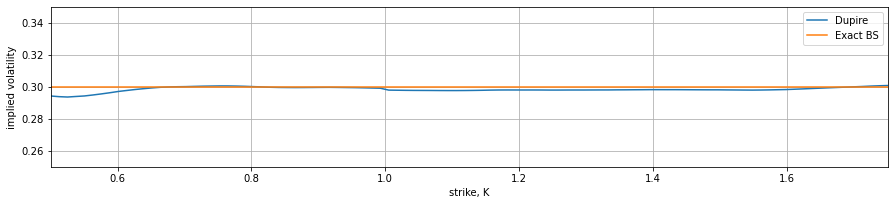

In [61]:
def mainCalculation():

    plt.figure(figsize=(15,10))
    T=1

    plt.subplot(3, 1, 1)

    K1 = np.linspace(0.5,1.75,100)
    K1 = np.array(K1).reshape([len(K1),1])

    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.5,1.75))
    plt.ylim((0.25,0.35))
#     plt.title("P_market: Mckean, T=1")
    legend = []

    L=[500,1000,2000,3000,5000,10000]
    

    LL0500 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:

            L0=[]
            for j in range(np.shape(B500)[1]):

                indices = np.nonzero(B500[:, j])[0]
                ST500 = np.array([B500[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST500,0))
                L0.append(V_market_Mckean1_P)

            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'p',T1,r)

        else:

            L0=[]
            for j in range(np.shape(B500)[1]):

                indices = np.nonzero(B500[:, j])[0]
                ST500 = np.array([B500[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(ST500-K1[idx],0))
                L0.append(V_market_Mckean1_P)

            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'c',T1,r)
    legend.append('{0}'.format("Dupire"))

    plt.plot(K1,LL0500)

            


    L_BS =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H1P = BS_Call_Option_Price('p',K1[idx],S_0,sigma,T1,r)
            L_BS[idx] = ImpliedVolatility(V_market_H1P,K1[idx],'p',T1,r)
        else:
            V_market_H1C = BS_Call_Option_Price('c',K1[idx],S_0,sigma,T1,r)
            L_BS[idx] = ImpliedVolatility(V_market_H1C,K1[idx],'c',T1,r)

    plt.plot(K1,L_BS)
    legend.append('{0}'.format("Exact BS"))


    plt.legend(legend)

    L1=[np.mean(np.abs(LL0500-L_BS))]
    L2=[np.sqrt(np.mean(np.abs(LL0500-L_BS)**2))]



    print("Error Mckean with 500 paths",L1[0])
    print("RMSE Error Mckean with paths",L2[0])
    

    C = 0.423
    print("C=0.423")
    print("Formula C/np.sqrt(Nbre of paths)")
    print("Error With formula paths ",C/np.sqrt(N0))







mainCalculation();

In [68]:
def Sigma_Dup_H(CP,r,S_0,t,S,kappa,gamma,vbar,v0,rho):
    
    deltaK=0.05
    deltaT=0.001
    
    cf0 = ChFHestonModel(r,t,kappa,gamma,vbar,v0,rho)
    cf1 = ChFHestonModel(r,t+deltaT,kappa,gamma,vbar,v0,rho)
    cf2 = ChFHestonModel(r,t-deltaT,kappa,gamma,vbar,v0,rho)
    
    a=((CallPutOptionPriceCOSMthd(cf1, CP , S_0, r, t+deltaT, S , 1000, 8)\
    -CallPutOptionPriceCOSMthd(cf2, CP , S_0, r, t-deltaT, S , 1000, 8))/ (2*deltaT)).reshape(-1,)
    
    b=((CallPutOptionPriceCOSMthd(cf0,CP , S_0, r, t, S-deltaK , 1000, 8)\
    -2*CallPutOptionPriceCOSMthd(cf0, CP , S_0, r, t, S , 1000, 8)\
    +CallPutOptionPriceCOSMthd(cf0,CP , S_0, r, t, S+deltaK , 1000, 8))/(deltaK**2)).reshape(-1,)
    
        
    Sig=(np.sqrt(np.abs(2*a/(S**2*b)))).reshape(-1,)
    
    return Sig

In [64]:
import enum 
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for Put Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

In [73]:
def GeneratePathsMckeanEuler(j,NoOfPaths,NoOfSteps,kappa,gamma,vbar,v0,rho,T,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y):   
    np.random.seed(j)

    E2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    
    
#     time = np.zeros([NoOfSteps+1])
    
    SC = np.zeros([NoOfPaths, NoOfSteps+1]) 
    
    SC[:,0]=S_0
    
    dt = T / float(NoOfSteps)
    
    E2[:,0] = (E2[:,0] - np.mean(E2[:,0])) / np.std(E2[:,0]) 

    
    SC[:,1] = S1_H[:,1]
    SC[:,1] = np.maximum(SC[:,1],0.0)


#     time[1]=dt
    
    for i in range(1,NoOfSteps):
        print(i)
        if NoOfPaths > 1:
            E2[:,i] = (E2[:,i] - np.mean(E2[:,i])) / np.std(E2[:,i])

            
#  Sigma Dupire

        t=i*dt
        Sig_Dp_C=(Sigma_Dup_H(OptionType.CALL,r,S_0,t,SC[:,i],kappa,gamma,vbar,v0,rho)).reshape(-1,)

#  Expectation
 
        

        
        SC[:,i+1] = SC[:,i] + SC[:,i]  * Sig_Dp_C  * np.power(dt, 0.5)*E2[:,i]       
        SC[:,i+1] = np.maximum(SC[:,i+1],0.0)

            
        inf_indices = np.where(np.isinf(SC[:, i+1]))[0]
        SC[inf_indices,i+1] = 0

        inf_indices0 = np.where(np.isnan(SC[:, i+1]))[0]
        SC[inf_indices0,i+1] = 0

        
#         time[i+1] = time[i] +dt
    
    paths = {"SC":SC}
    return paths



In [82]:
NoOfPaths1 = 10000
T1=1
Random_seed=14

Paths_H =  GeneratePathsHestonEuler(NoOfPaths1,M,T1,r,S_0,kappa,gamma,rho,vbar,v0)
S1_H = Paths_H["S"]

In [83]:
Paths_Mckean = GeneratePathsMckeanEuler(755,NoOfPaths1,M,kappa,gamma,vbar,v0,rho,T1,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y)
S1 = Paths_Mckean["SC"]

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/

Error Mckean with paths 0.0013394645521791699
Error Mckean with paths 0.0018466358742154035


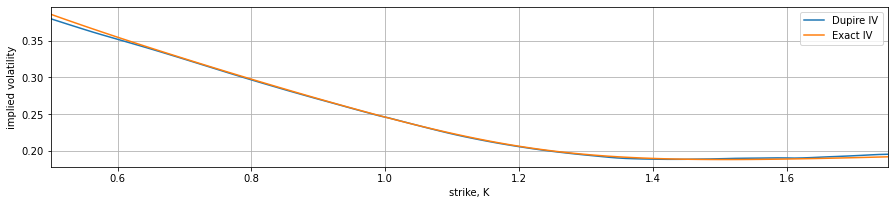

In [85]:
def mainCalculation():

    plt.figure(figsize=(15,10))
    T=1
    plt.subplot(3, 1, 1)

    K1 = np.linspace(0.5,1.75,100)
    K1 = np.array(K1).reshape([len(K1),1])

    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.5,1.75))
#     plt.ylim((0.25,0.35))
#     plt.title("P_market: Mckean, T=1")
    legend = []    

    LL0500 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:

            L0=[]
            for j in range(np.shape(S1)[1]):

                V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-S1[:,-1],0))
                L0.append(V_market_Mckean1_P)
            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'p',T,r)

        else:

            L0=[]
            for j in range(np.shape(S1)[1]):
                V_market_Mckean1_P=np.mean(np.maximum(S1[:,-1]-K1[idx],0))
                L0.append(V_market_Mckean1_P)

            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'c',T,r)
    plt.plot(K1,LL0500)
    legend.append('{0}'.format("Dupire IV"))


     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact IV"))


    plt.legend(legend)

    L1=[np.mean(np.abs(LL0500-L_H))]
    L2=[np.sqrt(np.mean(np.abs(LL0500-L_H)**2))]

    print("Error Mckean with paths",L1[0])
    print("Error Mckean with paths",L2[0])




mainCalculation();